In [2]:
import pandas as pd
import numpy as np

Считываем данные

In [2]:
train = pd.read_csv("./train.csv", sep=',')

Теперь пройдёмся по ним и в первую очередь уберём весь JSON, вытащив из него только полезную информацию. В зависимости от типа блока (поле type в json), нужно вытащить текст из соответствующего блока.

In [3]:
import json
from json import JSONDecodeError

for i,row in train.iterrows():
    text = row['content']
    if isinstance(text, float):
        pass
    try:
        js = json.loads(text)
        tmp = ""
        for el in js:
            if (el['type'] == 'CARD_IMAGE' or el['type'] == 'CARD_TEXT'):
                tmp += el['text']['blocks'][0]['text']
            elif (el['type'] == 'CARD_QUOTE' or el['type'] == 'IMAGE' or el['type'] == 'CARD_VIDEO'
                 or el['type'] == 'WIDGET' or el['type'] == 'STREAM' or el['type'] == 'VIDEO'
                 or el['type'] == 'AUDIO' or el['type'] == 'GALLERY' or el['type'] == 'SUBTITLE'):
                pass
            elif (el['type'] == 'QUOTE'):
                tmp += el['content']['blocks'][0]['text']
            else:
                for inEl in el['value']['blocks']:
                    tmp += inEl['text']
        train.set_value(i, 'content', tmp)
    except (JSONDecodeError, TypeError, KeyError):
        pass

Json почищен, однако много данных с html тэгами.
Избавимся от них, но чтобы несколько раз не перебирать датасет, сразу же будем токенизировать и нормализовать слова.

In [4]:
train

,post_id,published_at,title,subtitle,content
0,1,2017-01-01T00:05:00Z,Полиция Стамбула собирается штурмовать ночной ...,"Согласно последним данным, в здании может нахо...",<p>Полиция Стамбула собирается штурмовать ночн...
1,2,2017-01-01T00:07:00Z,Расстрел посетителей в ночном клубе в Стамбуле...,"Ранее сообщалось, что полицейские собираются ш...","<p>Опубликовано видео, где злоумышленник расст..."
2,3,2017-01-01T00:21:00Z,Губернатор Стамбула: При нападении на ночной к...,"Ранее сообщалось, что от 40 до 60 человек полу...",<p>Губернатор Стамбула <span>Васип Шахин</span...
3,4,2017-01-01T00:29:00Z,Губернатор Стамбула назвал террористической ат...,"Согласно последним данным, погибло минимум 35 ...",<p>Губернатор Стамбула Васип Шахин назвал терр...
4,5,2017-01-01T00:47:00Z,Очевидцы: В ночной клуб в Стамбуле проходили б...,Ранее губернатор Стамбула Васип Шахин назвал п...,"<p>Посетители стамбульского клуба ""Рейна"", на ..."
5,6,2017-01-01T00:56:00Z,"В турецком клубе, который был атакован террори...",NaN,"<p>Клуб ""Рейна"", на который сегодня было совер..."
6,7,2017-01-01T01:01:00Z,"Опубликовано видео из клуба ""Рейна"" за несколь...","Как ранее сообщалось, в результате атаки погиб...","<p>Опубликовано видео из стамбульского клуба ""..."
7,8,2017-01-01T01:01:00Z,Турецким СМИ запретили писать про теракт в Ста...,NaN,<p>Официальные власти Турции экстренно издали ...
8,9,2017-01-01T01:08:00Z,Губернатор Стамбула рассказал о нападении на к...,NaN,<p><span>По словам губернатора Стамбула Васипа...
9,10,2017-01-01T01:11:00Z,Опубликовано видео начала атаки на ночной клуб...,"На кадрах видно, как один злоумышленник с авто...",<p>В Сети появилось видео начала атаки на ночн...


In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from tqdm import tqdm
import re

from pymystem3 import Mystem
ms = Mystem()

wnl = WordNetLemmatizer()
stopwordss = stopwords.words('russian')

r_html = re.compile(r'<.*?>') # удаление html-тэгов
r_redund = re.compile('\w+') # токенизация
for i, row in train.iterrows():
    proccessing = str(row['title'])
    if (isinstance(row['subtitle'], str)):
        proccessing += ' ' + str(row['subtitle'])
    if (isinstance(row['content'], str)):
        proccessing += ' ' + str(row['content'])
 
    proccessing = r_html.sub('', proccessing)[:-1]
    proccessing = ' '.join(r_redund.findall(proccessing))
    normal_review = ''
    lemmas = ms.lemmatize(proccessing)
    for word in lemmas:
        if word not in stopwordss and word != ' ':
            normal_review += str(word) + ' '
    train.set_value(i, 'content', normal_review)

Пример текста, который получается после всех манипуляций.

In [23]:
train['content'][161]

'генконсульство рф стамбул подтвердить гибель россиянка время теракт возраст имя погибший пока разглашаться консульство пообещать полный информация появляться поздно информация жертва теракт ночной клуб рейн оказываться гражданка россия подтверждать лайф генконсульство россия стамбул слово дежурный консул погибший оказываться гражданка фамилия гасанов азербайджанка национальность российский паспорт возраст имя пока разглашаться полный информация появляться поздно иметь право выдавать сми пояснять консульство уточнять россиянин среди погибший среди раненый ранее предполагаться погибший являться гражданка азербайджан напоминать террорист совершать атака клуб рейн новогодний ночь убивать 39 человек ранить 69 преступник воспользоваться паника скрываться клуб время находиться около 800 человек весь ринуться выход услышать стрельба президент турция реджеп тайип эрдоган накануне заявлять теракт попытка посеять хаос страна президент рф владимир путин глава многий государство выражать соболезно

Экспортируем обработанные данные, чтобы при каждом запуске ноутбука не делать это заново.

In [24]:
train.to_csv('processed_data.csv', index=False)

In [3]:
train = pd.read_csv('processed_data.csv')

In [4]:
train

,post_id,published_at,title,subtitle,content
0,1,2017-01-01T00:05:00Z,Полиция Стамбула собирается штурмовать ночной ...,"Согласно последним данным, в здании может нахо...",полиция стамбул собираться штурмовать ночной к...
1,2,2017-01-01T00:07:00Z,Расстрел посетителей в ночном клубе в Стамбуле...,"Ранее сообщалось, что полицейские собираются ш...",расстрел посетитель ночной клуб стамбул попада...
2,3,2017-01-01T00:21:00Z,Губернатор Стамбула: При нападении на ночной к...,"Ранее сообщалось, что от 40 до 60 человек полу...",губернатор стамбул нападение ночной клуб погиб...
3,4,2017-01-01T00:29:00Z,Губернатор Стамбула назвал террористической ат...,"Согласно последним данным, погибло минимум 35 ...",губернатор стамбул называть террористический а...
4,5,2017-01-01T00:47:00Z,Очевидцы: В ночной клуб в Стамбуле проходили б...,Ранее губернатор Стамбула Васип Шахин назвал п...,очевидец ночной клуб стамбул проходить беспреп...
5,6,2017-01-01T00:56:00Z,"В турецком клубе, который был атакован террори...",NaN,турецкий клуб который атаковать террорист серь...
6,7,2017-01-01T01:01:00Z,"Опубликовано видео из клуба ""Рейна"" за несколь...","Как ранее сообщалось, в результате атаки погиб...",опубликовывать видео клуб рейн несколько час н...
7,8,2017-01-01T01:01:00Z,Турецким СМИ запретили писать про теракт в Ста...,NaN,турецкий сми запрещать писать теракт стамбул о...
8,9,2017-01-01T01:08:00Z,Губернатор Стамбула рассказал о нападении на к...,NaN,губернатор стамбул рассказывать нападение клуб...
9,10,2017-01-01T01:11:00Z,Опубликовано видео начала атаки на ночной клуб...,"На кадрах видно, как один злоумышленник с авто...",опубликовывать видео начало атака ночной клуб ...


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_df=0.35, min_df=0.005) 
# используем TfidfVectorizer с подобранными оптимальными параметрами

In [6]:
y = tfidf.fit_transform(train.content.values.astype('U')) # обучаем

In [7]:
len(tfidf.get_feature_names()) # количество выделенных фич

3017

Теперь сделаем предсказания для всех пар элементов, которые есть в sample_submission

In [29]:
samples = pd.read_csv("sample_submission.csv")

In [77]:
from sklearn.metrics.pairwise import cosine_similarity
answ = []
for smp in samples['id']:
    ind1, ind2 = str.split(smp, '_')
    first = y[train[train.post_id == int(ind1)].index[0]]
    second = y[train[train.post_id == int(ind2)].index[0]]
    a = cosine_similarity(first, second)[0][0]
    answ.append(a)

И запишем полученные результаты в файл

In [79]:
output = pd.DataFrame(data={"id": samples['id'], "similarity": answ})

In [80]:
output.to_csv('answer.csv', index=False)

# EDA

In [5]:
from wordcloud import WordCloud

In [10]:
stri = " ".join(train.content)

In [11]:
wordcloud = WordCloud().generate(stri)

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

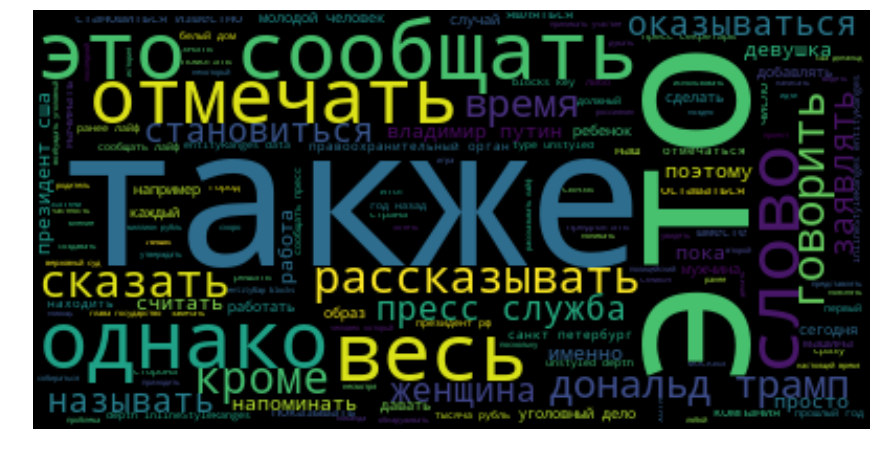

In [13]:
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [18]:
from PIL import Image
from os import path
alice_mask = np.array(Image.open(path.join("ai.jpg")))

In [25]:
wc = WordCloud(background_color="white", max_words=2000, mask=alice_mask)
# generate word cloud
wc.generate(stri)

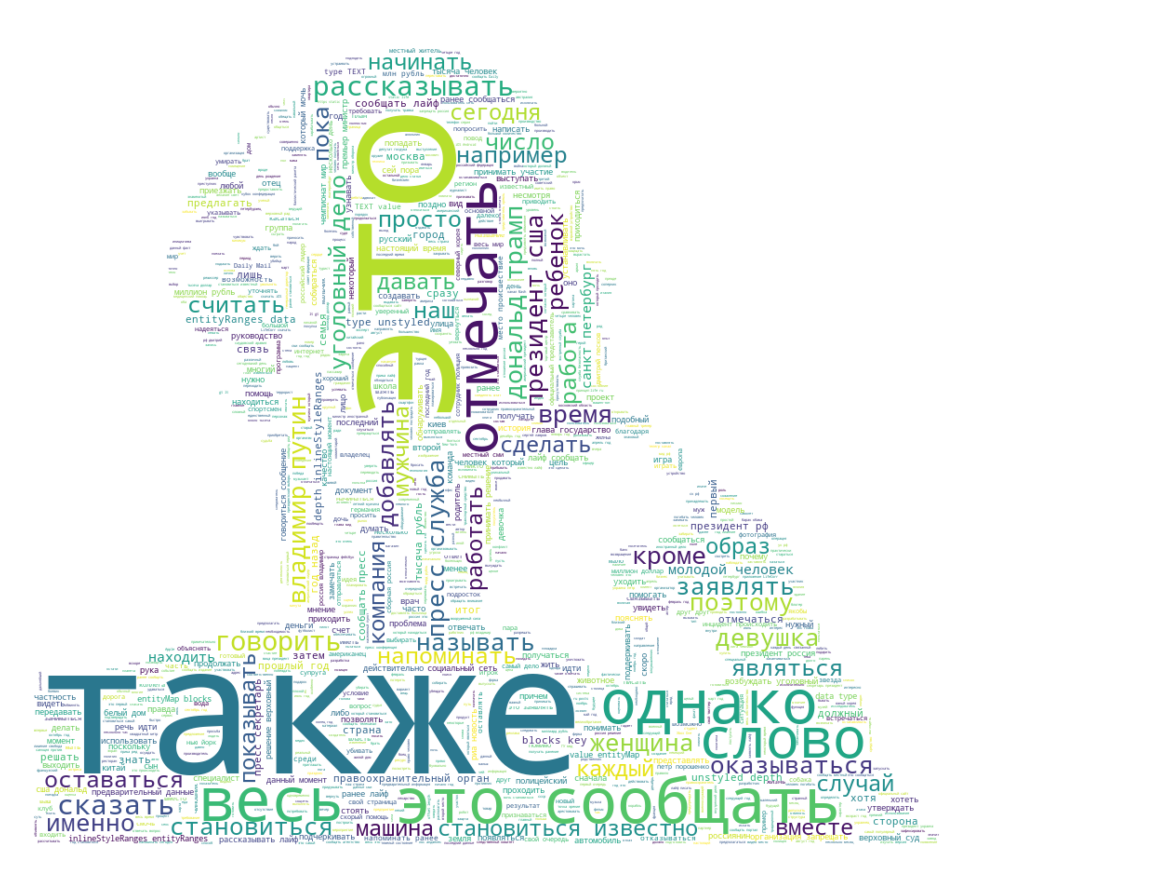

In [24]:
# store to file
wc.to_file(path.join("ai_ready.png"))

# show
plt.figure(figsize=(20, 20))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [31]:
import operator

In [32]:
sorted_x = sorted(tfidf.vocabulary_.items(), key=operator.itemgetter(1), reverse=True)

In [33]:
sorted_x

[('ясно', 3016),
 ('яркий', 3015),
 ('японский', 3014),
 ('япония', 3013),
 ('яндекс', 3012),
 ('январь', 3011),
 ('якобы', 3010),
 ('язык', 3009),
 ('ядерный', 3008),
 ('явно', 3007),
 ('являться', 3006),
 ('явление', 3005),
 ('юрист', 3004),
 ('юрий', 3003),
 ('юридический', 3002),
 ('юный', 3001),
 ('юлия', 3000),
 ('южный', 2999),
 ('юго', 2998),
 ('юг', 2997),
 ('эффективный', 2996),
 ('эффективность', 2995),
 ('эффект', 2994),
 ('эфир', 2993),
 ('этап', 2992),
 ('этаж', 2991),
 ('эпизод', 2990),
 ('энергия', 2989),
 ('энергетический', 2988),
 ('эмоция', 2987),
 ('элитный', 2986),
 ('элемент', 2985),
 ('электронный', 2984),
 ('экстренный', 2983),
 ('эксплуатация', 2982),
 ('экспертиза', 2981),
 ('эксперт', 2980),
 ('эксперимент', 2979),
 ('экс', 2978),
 ('экран', 2977),
 ('экономический', 2976),
 ('экономика', 2975),
 ('экипаж', 2974),
 ('эвакуировать', 2973),
 ('эвакуация', 2972),
 ('шутка', 2971),
 ('шутер', 2970),
 ('штраф', 2969),
 ('штат', 2968),
 ('штаб', 2967),
 ('шоу', 296

## Наиболее используемые слова

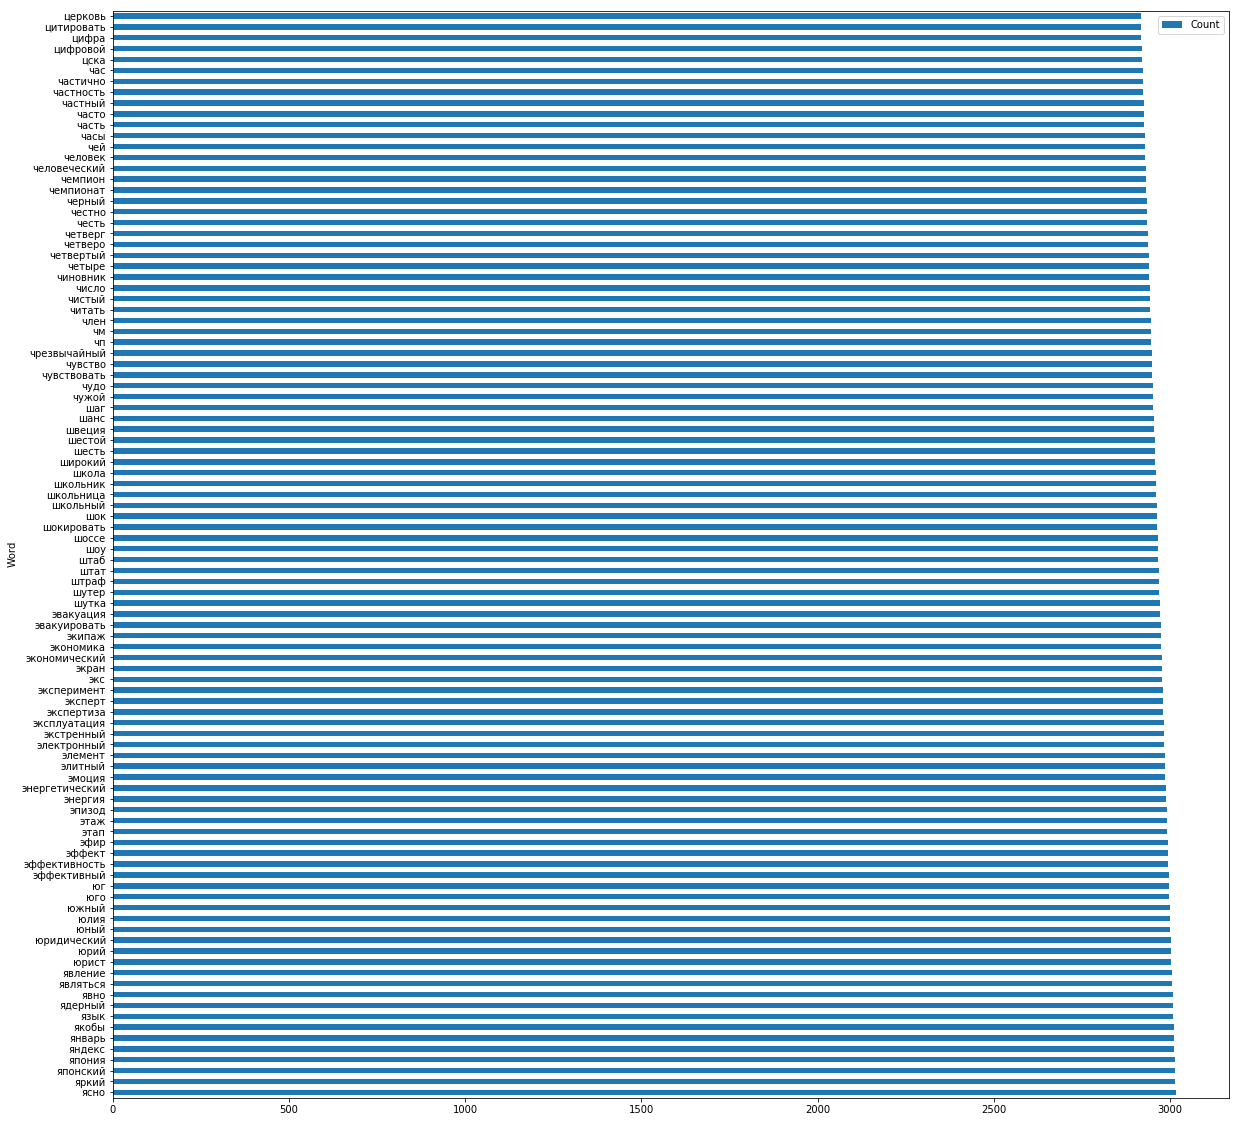

In [37]:
words = []
counts = []

for item in sorted_x[:100]:
    words.append(item[0])
    counts.append(item[1])
    
df = pd.DataFrame({'Word': words, 'Count': counts})

%matplotlib inline
df.plot.barh(x='Word',y='Count', figsize=(20, 20))

## Наименее используемые слова

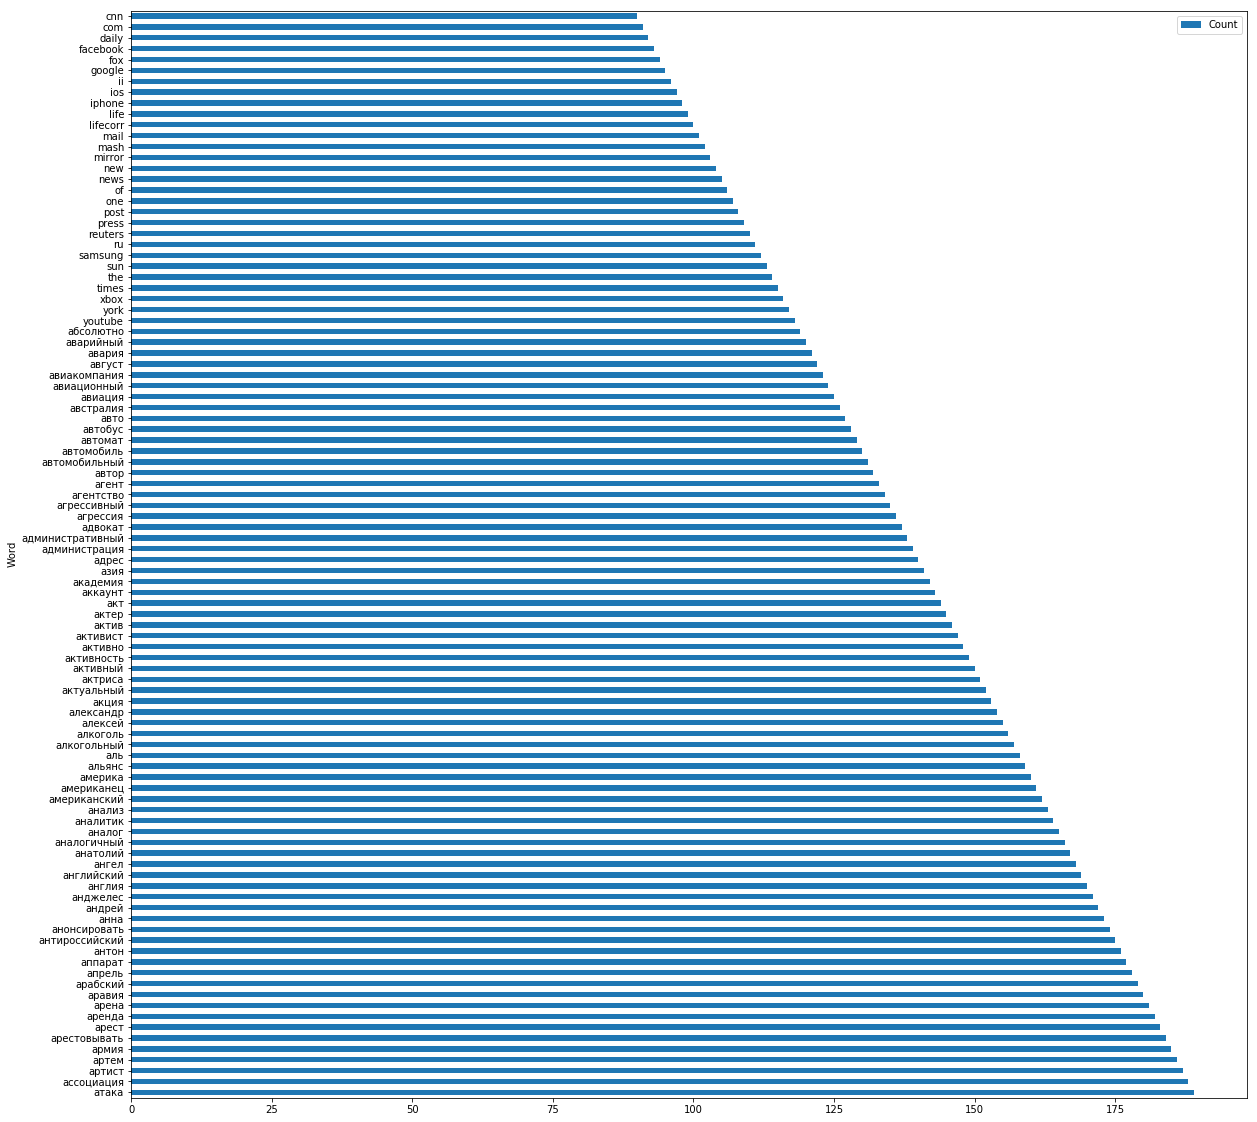

In [45]:
words = []
counts = []

for item in sorted_x[-190:-90]:
    words.append(item[0])
    counts.append(item[1])
    
df = pd.DataFrame({'Word': words, 'Count': counts})
%matplotlib inline
df.plot.barh(x='Word',y='Count', figsize=(20, 20))

Из наименее используемых слов выкинуты 90 самых неиспользуемых, т.к. это обычно несвязный набор букв/цифр, который мог появится в результате ошибок на этапе токенизации текстов.